<img src="https://i.ibb.co/wShF3QK/toronto-154805.jpg"/>

# Ontario house rent prediction
***
### Can you suggest house rent in ontario cities to new comers ?

**House rent in ontario especially in GTA gets even harder at scale**, considering the new immigrants in ontario, based on their preference lets try to predict prices in different cities.

**Kijiji**, Kijiji is an online classified advertising service that operates as a centralized network of online communities, organized by city and urban region, for posting local advertisements. 

In this project I scraped some datas from kijiji to build a dataset for training my ML model, which will help new comers to get an overall idea about the rent in a city based on their input. lets say if someone wants to move to Mississauga in a private room or shared basis, this model will predict the expected range of rent in the city based on the input.

**Recommendation**, City Recommendation will also be developed within this project to give the user some suggestions on cheapest nearby city to look for house rentals. -> Future Work :))


### Dataset Features

Since the dataset is scraped from kijiji website, I made some features that I think is relevent to this project and I tried to keep it minimal as possible.

- **Title**: Title of the advertisement
- **Description** : Description of the advertisement
- **Features** : Features of the advertisement. ( furnished or not, pet friendly or not etc)
- **Location** : Location of the property
- **Price** : Rent in CAD
- **Ddate Posted** : Posted date of the advertisement
- **URL** : advertisement url


# Import Packages

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.linear_model import Ridge
from bs4 import BeautifulSoup
import warnings
import re
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
dataset = pd.read_csv('kijiji.csv')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7440 entries, 0 to 7439
Data columns (total 9 columns):
adId            7440 non-null int64
Title           7440 non-null object
Price           7440 non-null object
Description     7440 non-null object
Location        7440 non-null object
Ddate Posted    7358 non-null object
Features        7439 non-null object
URL             7440 non-null object
Type            7440 non-null object
dtypes: int64(1), object(8)
memory usage: 523.2+ KB


In [4]:
dataset.columns

Index(['adId', 'Title', 'Price', 'Description', 'Location', 'Ddate Posted',
       'Features', 'URL', 'Type'],
      dtype='object')

In [5]:
dataset.head(1).style

,adId,Title,Price,Description,Location,Ddate Posted,Features,URL,Type
0,1444657385,"1 Bedroom plus Den Basement apartment. Sep entrance, parking.","$1,600.00","[DescriptionNicely renovated 1 bedroom plus den basement apartment. 1 minute from the 401. Both the bedroom and den are above ground level with windows looking into the backyard. Backs onto a park. Large living room area. A completely renovated single bathroom with stand up shower. New kitchen. Private laundry room, with new washer and dryer. Close to shopping area and bus stop. 1 Parking spot. Separate entrance. First and last months rent required. Required information: Letter of Employment 2 months pay stubs 2 references (one from previous landlord) Credit check required]","Oshawa, ON L1H2B7, Canada",3 days ago,"[Unit TypeBasement, Basement] || [Bedrooms2, 2] || [Bathrooms1, 1] || [Parking Included1, 1] || [Agreement Type1 Year, 1 Year] || [Move-In DateSeptember 16, 2019, September 16, 2019] || [Pet FriendlyNo, No] || [Size (sqft)900, 900] || [FurnishedNo, No] || [Air ConditioningNo, No] || [Smoking PermittedNo, No] ||",https://www.kijiji.ca/v-apartments-condos/oshawa-durham-region/1-bedroom-plus-den-basement-apartment-sep-entrance-parking/1444657385,v-apartments-condos


## Data Cleaning
***

Since we have a raw data it has to be processed to remove unwanted characters and html tags in each columns. We will be doing that first.


In [6]:
dataset.head()

,adId,Title,Price,Description,Location,Ddate Posted,Features,URL,Type
0,1444657385,1 Bedroom plus Den Basement apartment. Sep ent...,"$1,600.00","[<div class=""descriptionContainer-3544745383"">...","<span class=""address-3617944557"" itemprop=""add...","<time datetime=""2019-09-04T14:13:28.000Z"" titl...","[<div><h4 class=""realEstateLabel-3766429502"">U...",https://www.kijiji.ca/v-apartments-condos/osha...,v-apartments-condos
1,1457778936,HIGH PARK SPECTACULAR NEW ONE BEDROOM (Bloor W...,"$2,195.00","[<div class=""descriptionContainer-3544745383"">...","<span class=""address-3617944557"" itemprop=""add...","<time datetime=""2019-09-04T21:29:26.000Z"" titl...","[<div><h4 class=""realEstateLabel-3766429502"">U...",https://www.kijiji.ca/v-apartments-condos/city...,v-apartments-condos
2,1457544078,ATTENTION UTM STUDENTS (MALE ONLY),$495.00,"[<div class=""descriptionContainer-3544745383"">...","<span class=""address-3617944557"" itemprop=""add...","<time datetime=""2019-09-03T19:58:22.000Z"" titl...",Furnished : Yes || Pet Friendly : No ||,https://www.kijiji.ca/v-room-rental-roommate/m...,room rent
3,409446450,"Outdoor Storage & Self Storage (Contractors,RV...",Please Contact,"[<div class=""descriptionContainer-3544745383"">...","<span class=""address-3617944557"" itemprop=""add...","<time datetime=""2019-09-06T15:37:34.000Z"" titl...",More Info : Storage ||,https://www.kijiji.ca/v-storage-parking/city-o...,room rent
4,1445217185,YORKVILLE 1-Bedroom + Den Condo for RENT,Please Contact,"[<div class=""descriptionContainer-3544745383"">...","<span class=""address-3617944557"" itemprop=""add...","<time datetime=""2019-08-15T01:40:02.000Z"" titl...","[<div><h4 class=""realEstateLabel-3766429502"">U...",https://www.kijiji.ca/v-apartments-condos/city...,v-apartments-condos


In [7]:
#let's check missing values in the dataset
dataset.isnull().sum()

adId             0
Title            0
Price            0
Description      0
Location         0
Ddate Posted    82
Features         1
URL              0
Type             0
dtype: int64

### Price column

In [8]:
#lets remove $ symbol from the price column
# for any advertisement with " please contact " we will be replacing it with 0

def fixPriceColumn(price):
    try:
        rent = re.sub('[^0-9.]+', '', price)
        return(int(float(rent)))
    except:
        return 0

In [9]:
dataset['Price'] = dataset['Price'].apply(fixPriceColumn)

In [10]:
dataset[dataset['Price'] == 0].shape

(1268, 9)

In [11]:
# We have 410 items with rent of $0 out of 4000 advertisements. Let's take them out. 
#dataset = dataset[dataset['Price'] != 0]
#dataset.shape

### Description column

We have 3 kinds of list descriptions <br>
<pre>1.One with seperate list of Amenities as an unordered list.</pre> 
<pre>2.One with description in a Paragraph tag</pre> 
<pre>3.One with desciption within the div tag</pre>
We will have to consider these while extracting the text data from the html tags.<br>
We will be using BeautifulSoup library to make it easy.<br>

In [12]:
# a function to get the data from html tags
def cleanDescription(description):
    soup = BeautifulSoup(description, "html.parser")
    desc = []
    try:
        if len([link.get_text() for link in soup.select("ul > li")]) != 0:
            desc += [link.get_text() for link in soup.select("div > p")]
            desc += [link.get_text() for link in soup.select("ul > li")]
            return removeSymbols(str(desc))
        elif len([link.get_text() for link in soup.select("div > p")]) != 0:
            desc += [link.get_text() for link in soup.select("div > p")]
            return removeSymbols(str(desc))
        else:
            desc += [link.get_text() for link in soup.select("div")]
            #in this case we have to remove Description heading from the final text
            return removeSymbols(str(desc)[13:])
    except:
        return removeSymbols(str(desc))

In [13]:
def removeSymbols(text):
    return re.sub('[^A-Za-z0-9]+', ' ', text)

In [14]:
dataset['Description'] = dataset['Description'].apply(cleanDescription)

In [15]:
dataset.head()

,adId,Title,Price,Description,Location,Ddate Posted,Features,URL,Type
0,1444657385,1 Bedroom plus Den Basement apartment. Sep ent...,1600,Nicely renovated 1 bedroom plus den basement ...,"<span class=""address-3617944557"" itemprop=""add...","<time datetime=""2019-09-04T14:13:28.000Z"" titl...","[<div><h4 class=""realEstateLabel-3766429502"">U...",https://www.kijiji.ca/v-apartments-condos/osha...,v-apartments-condos
1,1457778936,HIGH PARK SPECTACULAR NEW ONE BEDROOM (Bloor W...,2195,Spectacular spacious one bedroom apartment wi...,"<span class=""address-3617944557"" itemprop=""add...","<time datetime=""2019-09-04T21:29:26.000Z"" titl...","[<div><h4 class=""realEstateLabel-3766429502"">U...",https://www.kijiji.ca/v-apartments-condos/city...,v-apartments-condos
2,1457544078,ATTENTION UTM STUDENTS (MALE ONLY),495,Room in excellent location right in front of ...,"<span class=""address-3617944557"" itemprop=""add...","<time datetime=""2019-09-03T19:58:22.000Z"" titl...",Furnished : Yes || Pet Friendly : No ||,https://www.kijiji.ca/v-room-rental-roommate/m...,room rent
3,409446450,"Outdoor Storage & Self Storage (Contractors,RV...",0,Bentworth Outdoor Storage is Toronto s larges...,"<span class=""address-3617944557"" itemprop=""add...","<time datetime=""2019-09-06T15:37:34.000Z"" titl...",More Info : Storage ||,https://www.kijiji.ca/v-storage-parking/city-o...,room rent
4,1445217185,YORKVILLE 1-Bedroom + Den Condo for RENT,0,Fully Furnished 1 Bedroom Den Suite for RENT ...,"<span class=""address-3617944557"" itemprop=""add...","<time datetime=""2019-08-15T01:40:02.000Z"" titl...","[<div><h4 class=""realEstateLabel-3766429502"">U...",https://www.kijiji.ca/v-apartments-condos/city...,v-apartments-condos


In [16]:
#let's check if we have any empty descriptions
dataset[dataset['Description'].str.split(" ").str.len() == 0]

,adId,Title,Price,Description,Location,Ddate Posted,Features,URL,Type


### Location column

In [17]:
# the data we have, we have to extract address and postal code from this
dataset['Location'][0]

'<span class="address-3617944557" itemprop="address" itemscope="" itemtype="http://schema.org/PostalAddress">Oshawa, ON L1H2B7, Canada</span>'

In [18]:
def getAddress(address):
    soup = BeautifulSoup(address, "html.parser")
    add = ""
    postal = ""
    regex = '[A^a-zA-Z]{1}[0-9]{1}[A^a-zA-Z]{1}[0-9]{1}[A^a-zA-Z]{1}[0-9]{1}'
    try:
        givenAddress = str([link.get_text() for link in soup.select("span")])
        givenAddress = removeSymbols(givenAddress)
        postalAddress = givenAddress.replace(" ","")
        postal = re.search(regex,postalAddress)
        return givenAddress,postal.group(0)
    except:
        return givenAddress,postal

In [19]:
dataset['Location'],dataset['Postal_Code'] = zip(*dataset['Location'].apply(getAddress))

In [20]:
dataset.head(2)

,adId,Title,Price,Description,Location,Ddate Posted,Features,URL,Type,Postal_Code
0,1444657385,1 Bedroom plus Den Basement apartment. Sep ent...,1600,Nicely renovated 1 bedroom plus den basement ...,Oshawa ON L1H2B7 Canada,"<time datetime=""2019-09-04T14:13:28.000Z"" titl...","[<div><h4 class=""realEstateLabel-3766429502"">U...",https://www.kijiji.ca/v-apartments-condos/osha...,v-apartments-condos,L1H2B7
1,1457778936,HIGH PARK SPECTACULAR NEW ONE BEDROOM (Bloor W...,2195,Spectacular spacious one bedroom apartment wi...,236 S Kingsway Toronto ON M6S 3T9 Canada,"<time datetime=""2019-09-04T21:29:26.000Z"" titl...","[<div><h4 class=""realEstateLabel-3766429502"">U...",https://www.kijiji.ca/v-apartments-condos/city...,v-apartments-condos,M6S3T9


### Date Posted Column

In [21]:
## we have arround 30 missing values in date posted column due to some exception while scraping
## we will be filling those values with the date I scraped the site. I.e Sep 4 2019
dataset['Ddate Posted'].fillna(value = '2019-09-04', inplace=True)

In [22]:
dataset['Ddate Posted'][550]

'<time datetime="2019-08-24T00:10:37.000Z" title="August 24, 2019 12:10 AM">15 days ago</time>'

In [23]:
def getDate(datePosted):
    try:
        date = str(datePosted[16:26])
        return date
    except:
        print(datePosted)

In [24]:
dataset['Date_Posted'] = dataset['Ddate Posted'].apply(getDate)

In [25]:
dataset.drop('Ddate Posted',inplace=True,axis=1)

In [26]:
dataset.head(2)

,adId,Title,Price,Description,Location,Features,URL,Type,Postal_Code,Date_Posted
0,1444657385,1 Bedroom plus Den Basement apartment. Sep ent...,1600,Nicely renovated 1 bedroom plus den basement ...,Oshawa ON L1H2B7 Canada,"[<div><h4 class=""realEstateLabel-3766429502"">U...",https://www.kijiji.ca/v-apartments-condos/osha...,v-apartments-condos,L1H2B7,2019-09-04
1,1457778936,HIGH PARK SPECTACULAR NEW ONE BEDROOM (Bloor W...,2195,Spectacular spacious one bedroom apartment wi...,236 S Kingsway Toronto ON M6S 3T9 Canada,"[<div><h4 class=""realEstateLabel-3766429502"">U...",https://www.kijiji.ca/v-apartments-condos/city...,v-apartments-condos,M6S3T9,2019-09-04


### Features Column

In [27]:
dataset.Features.isnull().sum()

1

In [28]:
dataset= dataset.dropna(subset=['Features'])

In [29]:
def getFeaturesOfUnitType(feature):
    features_wanted = ['Unit Type','Bedrooms','Bathrooms','Pet Friendly','Furnished','Parking Included',
                  'Air Conditioning','Smoking Permitted']
    #lets initialize some basic features
    unittype = 'House'
    bedrooms = 1
    bathrooms = 1
    petfriendly = 0 # 0 for NO and 1 for Yes
    furnished = 0 # 0 for NO and 1 for Yes
    parkingincluded = 1 # 0 for NO and 1 for Yes
    airconditioning = 1 # 0 for NO and 1 for Yes
    smokingpermitted = 0 # 0 for NO and 1 for Yes
    soup = BeautifulSoup(feature, "html.parser") 
    try:
        feature = [link.get_text() for link in soup.select("h4")]
        featureCondition = [link.get_text() for link in soup.select("div > div")]
        for item in feature:
            if item in features_wanted:
                ftName = item.lower().replace(" ","")
                if ftName == 'unittype':
                    cond = featureCondition[feature.index(item)]
                    unittype = cond
                    
                elif ftName == 'bedrooms':
                    cond = featureCondition[feature.index(item)]
                    bedrooms = cond        
                 
                elif ftName == 'bathrooms':
                    cond = featureCondition[feature.index(item)]
                    bathrooms = cond                   
                        
                elif ftName == 'petfriendly':
                    cond = featureCondition[feature.index(item)]
                    if cond == 'Yes':
                        petfriendly = 1
                    elif cond == 'No':
                        petfriendly = 0
                        
                elif ftName == 'furnished':
                    cond = featureCondition[feature.index(item)]
                    if cond == 'Yes':
                        furnished = 1
                    elif cond == 'No':
                        furnished = 0
 
                elif ftName == 'airconditioning':
                    cond = featureCondition[feature.index(item)]
                    if cond == 'Yes':
                        airconditioning = 1
                    elif cond == 'No':
                        airconditioning = 0

                elif ftName == 'smokingpermitted':
                    cond = featureCondition[feature.index(item)]
                    if cond == 'Yes':
                        smokingpermitted = 1
                    elif cond == 'No':
                        smokingpermitted = 0
                    
                elif ftName == 'parkingincluded':
                    cond = featureCondition[feature.index(item)]
                    if cond == 'Yes':
                        parkingincluded = 1
                    elif cond == 'No':
                        parkingincluded = 0 
                
        return unittype,bedrooms,bathrooms,petfriendly,furnished,parkingincluded,airconditioning,smokingpermitted
    except:
        return unittype,bedrooms,bathrooms,petfriendly,furnished,parkingincluded,airconditioning,smokingpermitted

In [30]:
# Generate new features from feature column

In [31]:
dataset['unittype'],dataset['bedrooms'],dataset['bathrooms'] \
,dataset['petfriendly'],dataset['furnished'],dataset['parkingincluded'] \
,dataset['airconditioning'],dataset['smokingpermitted'] = zip(*dataset['Features'].apply(getFeaturesOfUnitType))

In [32]:
#lets double check if any of the new features still need processing

In [33]:
dataset['unittype'].unique()

array(['Basement', 'Apartment', 'House', 'Condo', 'Townhouse',
       'Duplex/Triplex'], dtype=object)

In [34]:
dataset['bedrooms'].unique()

array(['2', '1', 1, '1 + Den', '4', '3', 'Bachelor/Studio', '2 + Den',
       '3 + Den', '4 + Den', '5+'], dtype=object)

In [35]:
dataset['bathrooms'].unique()

array(['1', 1, '4', '2', '3.5', '2.5', '3', '1.5', '4.5', '5'],
      dtype=object)

In [36]:
#a function to clean the new generated features
def convertToBedFloat(value):
    if 'Den' in str(value):
        rooms = value.split(" ")
        rooms = float(rooms[0])
        rooms += 0.5
    elif 'Bachelor/Studio' in str(value):
        rooms = 1.0
    else:
        value = removeSymbols(str(value))
        rooms = float(value)
    return rooms

def convertToBathFloat(value):
    return float(value)

In [37]:
dataset['bathrooms'] = dataset['bathrooms'].apply(convertToBathFloat)

In [38]:
dataset['bedrooms'] = dataset['bedrooms'].apply(convertToBedFloat)

In [39]:
dataset.drop('Features',inplace=True,axis=1)

In [40]:
dataset.head(2)

,adId,Title,Price,Description,Location,URL,Type,Postal_Code,Date_Posted,unittype,bedrooms,bathrooms,petfriendly,furnished,parkingincluded,airconditioning,smokingpermitted
0,1444657385,1 Bedroom plus Den Basement apartment. Sep ent...,1600,Nicely renovated 1 bedroom plus den basement ...,Oshawa ON L1H2B7 Canada,https://www.kijiji.ca/v-apartments-condos/osha...,v-apartments-condos,L1H2B7,2019-09-04,Basement,2.0,1.0,0,0,1,0,0
1,1457778936,HIGH PARK SPECTACULAR NEW ONE BEDROOM (Bloor W...,2195,Spectacular spacious one bedroom apartment wi...,236 S Kingsway Toronto ON M6S 3T9 Canada,https://www.kijiji.ca/v-apartments-condos/city...,v-apartments-condos,M6S3T9,2019-09-04,Apartment,1.0,1.0,0,0,1,0,0


In [41]:
dataset.Postal_Code.nunique()

1847

### URL Column

In [42]:
dataset.URL.isnull().sum()

0

In [43]:
def getRegion(region):
    url = region.split("/")
    location = url[4]
    return location.replace("-"," ").replace("region","").rstrip()

In [44]:
dataset['region'] = dataset['URL'].apply(getRegion)

In [45]:
dataset.region.unique()

array(['oshawa durham', 'city of toronto', 'mississauga peel', 'london',
       'kitchener waterloo', 'markham york', 'kingston on',
       'windsor area on', 'cornwall on', 'hamilton', 'ottawa',
       'leamington', 'barrie', 'guelph', 'north bay', 'gatineau',
       'oakville halton', 'napanee', 'norfolk county', 'st catharines',
       'chatham kent', 'sudbury', 'thunder bay', 'peterborough', 'sarnia',
       'belleville', 'cambridge', 'sault ste marie', 'trenton on',
       'owen sound', 'brockville', 'woodstock on', 'stratford on',
       'brantford', 'kawartha lakes', 'muskoka', 'grand bend', 'timmins',
       'kapuskasing'], dtype=object)

In [46]:
dataset.region.nunique()

39

In [47]:
a = dataset.region.unique()

In [48]:
a[1].replace("-"," ").replace("region","").rstrip()

'city of toronto'

In [49]:
# Lets remove unwanted Columns

In [50]:
dataset.drop('URL',inplace=True,axis=1)
dataset.drop('Type',inplace=True,axis=1)
dataset.drop('Location',inplace=True,axis=1)
dataset.drop('Title',inplace=True,axis=1)
dataset.drop('adId',inplace=True,axis=1)

In [51]:
dataset.head(2)

,Price,Description,Postal_Code,Date_Posted,unittype,bedrooms,bathrooms,petfriendly,furnished,parkingincluded,airconditioning,smokingpermitted,region
0,1600,Nicely renovated 1 bedroom plus den basement ...,L1H2B7,2019-09-04,Basement,2.0,1.0,0,0,1,0,0,oshawa durham
1,2195,Spectacular spacious one bedroom apartment wi...,M6S3T9,2019-09-04,Apartment,1.0,1.0,0,0,1,0,0,city of toronto


## Summary Statistics:

In [52]:
dataset.astype('object').describe().transpose()

,count,unique,top,freq
Price,7439,464,0,1268
Description,7439,2178,Elevator Security Card Access Above ground pa...,225
Postal_Code,7257,1847,M4Y1H3,225
Date_Posted,7439,33,2019-09-06,5661
unittype,7439,6,Apartment,3327
bedrooms,7439,9,1,4510
bathrooms,7439,9,1,6291
petfriendly,7439,2,0,5068
furnished,7439,2,0,7042
parkingincluded,7439,1,1,7439


<pre> We have around 1200 listing with price less than 200$, Lets drop those rows for now.</pre> 

In [ ]:
# min rent $1 
# this must me some kind of wrong listing in kijiji and we dont want to feed this to our model

In [55]:
df = dataset.drop(dataset[dataset.Price < 200].index)

In [56]:
df.describe()

,Price,bedrooms,bathrooms,petfriendly,furnished,parkingincluded,airconditioning,smokingpermitted
count,6060.000000,6060.000000,6060.000000,6060.000000,6060.000000,6060.0,6060.000000,6060.000000
mean,2261.909901,1.563861,1.226568,0.352145,0.060396,1.0,0.878713,0.012211
std,21987.021827,0.839809,0.555163,0.477678,0.238239,0.0,0.326488,0.109837
min,200.000000,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000
25%,1150.000000,1.000000,1.000000,0.000000,0.000000,1.0,1.000000,0.000000
50%,1700.000000,1.000000,1.000000,0.000000,0.000000,1.0,1.000000,0.000000
75%,2110.000000,2.000000,1.000000,1.000000,0.000000,1.0,1.000000,0.000000
max,1000000.000000,5.000000,5.000000,1.000000,1.000000,1.0,1.000000,1.000000


In [57]:
df.astype('object').describe().transpose()

,count,unique,top,freq
Price,6060,439,2300,316
Description,6060,1826,Elevator Security Card Access Above ground pa...,225
Postal_Code,5921,1575,M4Y1H3,225
Date_Posted,6060,32,2019-09-06,4575
unittype,6060,6,Apartment,2674
bedrooms,6060,9,1,3759
bathrooms,6060,9,1,4991
petfriendly,6060,2,0,3926
furnished,6060,2,0,5694
parkingincluded,6060,1,1,6060


# Exploratory Data Analysis

In [58]:
df.head(2)

,Price,Description,Postal_Code,Date_Posted,unittype,bedrooms,bathrooms,petfriendly,furnished,parkingincluded,airconditioning,smokingpermitted,region
0,1600,Nicely renovated 1 bedroom plus den basement ...,L1H2B7,2019-09-04,Basement,2.0,1.0,0,0,1,0,0,oshawa durham
1,2195,Spectacular spacious one bedroom apartment wi...,M6S3T9,2019-09-04,Apartment,1.0,1.0,0,0,1,0,0,city of toronto


### Examine Target Value (Price)

In [59]:
df.Price.describe()

count       6060.000000
mean        2261.909901
std        21987.021827
min          200.000000
25%         1150.000000
50%         1700.000000
75%         2110.000000
max      1000000.000000
Name: Price, dtype: float64

# Rent Distribution
**Summary:**
- The mean price in the dataset is **2261 Dollars**
- The median price in the dataset is **1700 Dollars**
- The max price in the dataset is **1000000 Dollars** # mostly a whole house 
- Most item prices are at about **1150 Dollars**

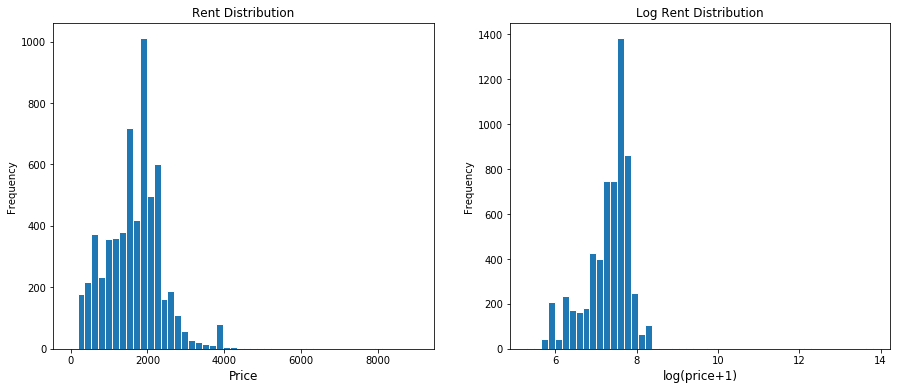

In [60]:
# Plot Price Distribution
plt.subplot(1, 2, 1)
(df['Price']).plot.hist(bins=50, figsize=(15, 6), edgecolor = 'white', range = [0, 9000])
plt.xlabel('Price', fontsize=12)
plt.title('Rent Distribution', fontsize=12)
#Plot Log Price Distribution
plt.subplot(1, 2, 2)
np.log(df['Price']+1).plot.hist(bins=50, figsize=(15,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Log Rent Distribution', fontsize=12)

plt.show()

**Why take log(Rent)?** 

We can see that more then 50% of the listings were under 2000$ so in order to make errors on low rent is more relevant than for higher rent lisiting.

**Step 1 Log Transformation:** np.log(dataset['Price']+1)

**Step 2 Predict with Log Transformation:** test_pred = model.predict(X_test)

**Step 3 Convert back to original value by Exponential Transformation** Y_test = np.expm1(test_pred)

## Rent Distribution by Unit Type


Seems about right. Living in apartment does increase the rent and living in basement costs very less.

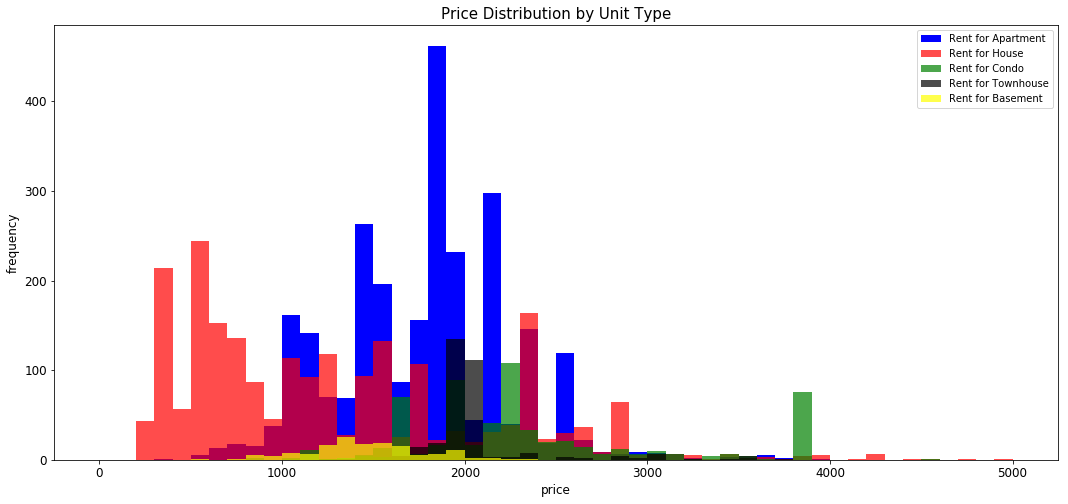

In [61]:
rentForApartment = df.loc[df['unittype'] == 'Apartment', 'Price']
rentForHouse = df.loc[df['unittype'] == 'House', 'Price']
rentForCondo = df.loc[df['unittype'] == 'Condo', 'Price']
rentForTownhouse = df.loc[df['unittype'] == 'Townhouse', 'Price']
rentForBasement = df.loc[df['unittype'] == 'Basement', 'Price']

fig, ax = plt.subplots(figsize=(18,8))

ax.hist(rentForApartment, color='blue', alpha=1.0, bins=50, range = [0, 5000],label='Rent for Apartment')
ax.hist(rentForHouse, color='red', alpha=0.7, bins=50, range = [0, 5000],label='Rent for House')
ax.hist(rentForCondo, color='green', alpha=0.7, bins=50, range = [0, 5000],label='Rent for Condo')
ax.hist(rentForTownhouse, color='black', alpha=0.7, bins=50, range = [0, 5000],label='Rent for Townhouse')
ax.hist(rentForBasement, color='yellow', alpha=0.7, bins=50, range = [0, 5000],label='Rent for Basement')

plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Unit Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [62]:
def plotBarCharts(val):
    rent_pivot = \
    df.pivot_table(index=val, values="Price", aggfunc=np.mean)
    rent_pivot.plot(kind='bar', color='blue',figsize=(14,5))
    plt.xlabel(val)
    plt.ylabel("Price")
    plt.title(val+" and Average Rent Analysis")
    plt.xticks(rotation=0)
    plt.show()

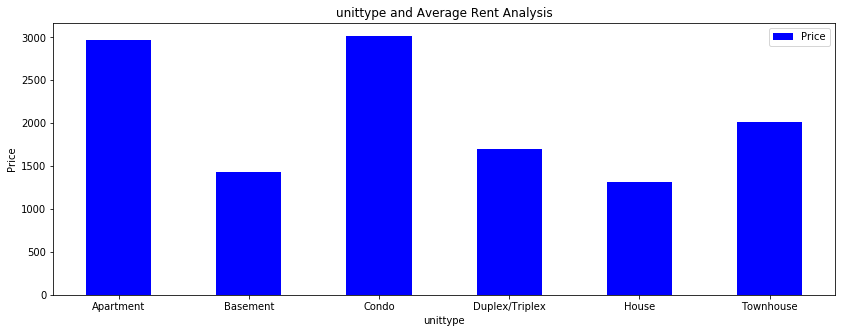

In [63]:
plotBarCharts('unittype')

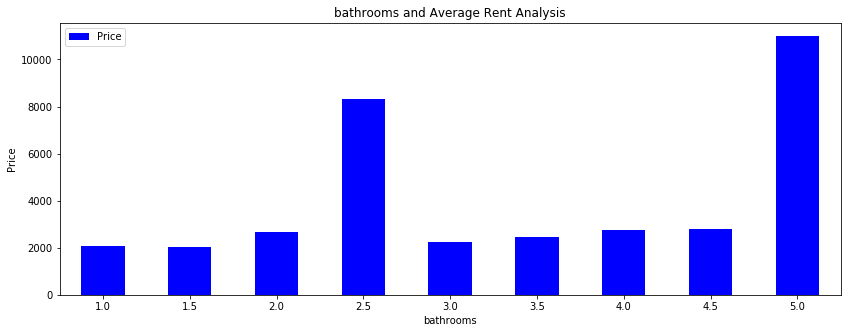

In [64]:
plotBarCharts('bathrooms')

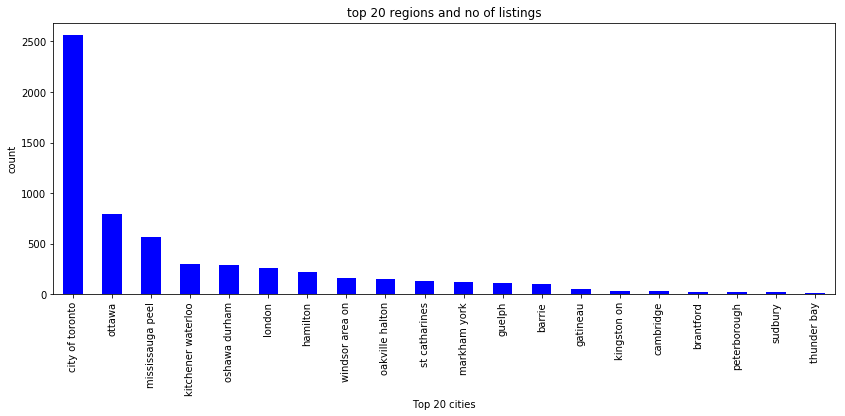

In [65]:
top_cities = df.region.value_counts()[:20]
top_cities.plot(kind='bar', color='blue',figsize=(14,5))
plt.xlabel("Top 20 cities")
plt.ylabel("count")
plt.title("top 20 regions and no of listings")
plt.xticks()
plt.show()

# Text Processing
***
Let's normalize the words in description by:
- Removing Stop Words
- Lowercasing the Words
- Stemming the Words

### List of Stop Words

In [66]:
# Examine list of stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

### Create Functions to Normalize the Words

In [67]:
import string

# Create a function to remove stop words
def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

# Create a function to lowercase the words
def to_lower(x):
    return x.lower()


### Apply Normalizing Functions

In [68]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

In [69]:
df['Description'] = df['Description'].apply(porter.stem)

In [70]:
df['Description'] = df['Description'].apply(remove_stop_words)

In [71]:
df['Description'] = df['Description'].apply(to_lower)

In [72]:
df.head(2)

,Price,Description,Postal_Code,Date_Posted,unittype,bedrooms,bathrooms,petfriendly,furnished,parkingincluded,airconditioning,smokingpermitted,region
0,1600,nicely renovated 1 bedroom plus den basement ...,L1H2B7,2019-09-04,Basement,2.0,1.0,0,0,1,0,0,oshawa durham
1,2195,spectacular spacious one bedroom apartment 5 ...,M6S3T9,2019-09-04,Apartment,1.0,1.0,0,0,1,0,0,city of toronto


# Build BASE MODELS
***
- let's build bases models with Description as a feature to predict the price.
- Since its a regression task we will be using ridge regression model

In [73]:
X_train = df.iloc[:,1:]
y_train = np.log1p(df['Price'])

## Analyzing Item Description with Eli5
***

- Eli5 is a library that allows you to see what your model has learned from the text features.

In [74]:
# Definte RMSLE Cross Validation Function
def rmsle_cv(model):
    kf = KFold(shuffle=True, random_state=42).get_n_splits(X_train['Description'])
    rmse= np.sqrt(-cross_val_score(model, X_train['Description'], y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse.mean())

## Baseline Model with CountVectorizer

In [75]:
vec = CountVectorizer()
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(X_train['Description'], y_train)

cv_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(cv_rmsle))

The Validation Score is: 0.31224221907326216


In [76]:
#!pip install eli5
import eli5
eli5.show_weights(pipe, vec=vec, top=100, feature_filter=lambda x: x != '<BIAS>')

Using TensorFlow backend.


Weight?,Feature
+0.628,none
+0.287,economic
+0.287,stall
+0.274,fees
+0.272,taxes
+0.267,juravinski
+0.262,co
+0.247,brow
+0.246,op
+0.228,sale


In [77]:
eli5.show_prediction(clf, doc=X_train['Description'][1297], vec=vec)

## Baseline Model with CountVectorizer and Stop Words

In [78]:
vec = CountVectorizer(stop_words='english')
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(X_train['Description'], y_train)

cv_sw_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(cv_sw_rmsle))

The Validation Score is: 0.31544971268811833


In [79]:
eli5.show_prediction(clf, doc=X_train['Description'][1297], vec=vec)

## Baseline Model with TF-IDF

In [80]:
vec = TfidfVectorizer()
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(X_train['Description'], y_train)

tfidf_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_rmsle))

The Validation Score is: 0.2695070820165231


In [81]:
eli5.show_prediction(clf, doc=X_train['Description'][1297], vec=vec)

## Baseline Model with TF-IDF and Stop Words

In [82]:
vec = TfidfVectorizer(stop_words='english')
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(X_train['Description'], y_train)

tfidf_sw_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_sw_rmsle))

The Validation Score is: 0.28308286384996234


In [83]:
eli5.show_prediction(clf, doc=X_train['Description'][1297], vec=vec)

## Baseline Model with TF-IDF, Stop Words, and N-Grams

In [84]:
vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(X_train['Description'], y_train)

tfidf_sw_ng_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_sw_ng_rmsle))

The Validation Score is: 0.2766854091016913


In [85]:
eli5.show_prediction(clf, doc=X_train['Description'][1297], vec=vec)

## RMSLE Summary

TF-IDF + Stop Words + N-Grams works best

In [86]:
print ("RMSLE Score: " + str(cv_rmsle) + " | CountVectorizer")
print ("RMSLE Score: " + str(cv_sw_rmsle) + " | CountVectorizer | Stop Words")
print ("RMSLE Score: " + str(tfidf_rmsle) + " | TF-IDF")
print ("RMSLE Score: " + str(tfidf_sw_rmsle) + " | TF-IDF | Stop Words")
print ("RMSLE Score: " + str(tfidf_sw_ng_rmsle) + " | TF-IDF | Stop Words | N-Grams")

RMSLE Score: 0.31224221907326216 | CountVectorizer
RMSLE Score: 0.31544971268811833 | CountVectorizer | Stop Words
RMSLE Score: 0.2695070820165231 | TF-IDF
RMSLE Score: 0.28308286384996234 | TF-IDF | Stop Words
RMSLE Score: 0.2766854091016913 | TF-IDF | Stop Words | N-Grams


***
# Feature Pre-Processing / Transformation

It's super modular. So you have an estimator or a transformer, then you have a pipeline, then you connect more than one transformations together

In [87]:
X_train.head(2)

,Description,Postal_Code,Date_Posted,unittype,bedrooms,bathrooms,petfriendly,furnished,parkingincluded,airconditioning,smokingpermitted,region
0,nicely renovated 1 bedroom plus den basement ...,L1H2B7,2019-09-04,Basement,2.0,1.0,0,0,1,0,0,oshawa durham
1,spectacular spacious one bedroom apartment 5 ...,M6S3T9,2019-09-04,Apartment,1.0,1.0,0,0,1,0,0,city of toronto


In [124]:
from sklearn.pipeline import FeatureUnion

default_preprocessor = CountVectorizer().build_preprocessor()

def build_preprocessor(field):
    field_idx = list(X_train.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])

vectorizer = FeatureUnion([
    ('region', CountVectorizer(
        ngram_range=(1, 2),
        max_features=50000,
        preprocessor=build_preprocessor('region'))),
    ('smokingpermitted', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('smokingpermitted'))),
    ('airconditioning', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('airconditioning'))),
    ('parkingincluded', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('parkingincluded'))),
    ('furnished', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('furnished'))),
    ('petfriendly', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('petfriendly'))),
    ('bathrooms', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('bathrooms'))),
    ('bedrooms', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('bedrooms'))),
    ('unittype', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('unittype'))),
    ('Description', TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=55000,
        stop_words='english',
        preprocessor=build_preprocessor('Description'))),
])

# Modeling

- Ridge Regression

## Fast Data Cleaning

In [ ]:
X_train.drop('Date_Posted',axis=1,inplace=True)

In [119]:
X_train.drop('Postal_Code',axis=1,inplace=True)

In [126]:
X_train.dtypes

Description          object
unittype             object
bedrooms            float64
bathrooms           float64
petfriendly           int64
furnished             int64
parkingincluded       int64
airconditioning       int64
smokingpermitted      int64
region               object
dtype: object

In [127]:
X_train['bedrooms'] = X_train['bedrooms'].astype(str)
X_train['bathrooms'] = X_train['bathrooms'].astype(str)
X_train['petfriendly'] = X_train['petfriendly'].astype(str)
X_train['parkingincluded'] = X_train['parkingincluded'].astype(str)
X_train['furnished'] = X_train['furnished'].astype(str)
X_train['airconditioning'] = X_train['airconditioning'].astype(str)
X_train['smokingpermitted'] = X_train['smokingpermitted'].astype(str)

### Create Transformed Training Set

In [120]:
X_train.head(2)

,Description,unittype,bedrooms,bathrooms,petfriendly,furnished,parkingincluded,airconditioning,smokingpermitted,region
0,nicely renovated 1 bedroom plus den basement ...,Basement,2.0,1.0,0,0,1,0,0,oshawa durham
1,spectacular spacious one bedroom apartment 5 ...,Apartment,1.0,1.0,0,0,1,0,0,city of toronto


In [128]:
# Create Transformed Train Set
Xt_train = vectorizer.fit_transform(X_train.values)
Xt_train

<6060x55105 sparse matrix of type '<class 'numpy.float64'>'
	with 791239 stored elements in Compressed Sparse Row format>

### Create Train/Test Split

In [130]:
# Train and Test Split
train_X, test_X, train_y, test_y = train_test_split(Xt_train, y_train, test_size=0.2, random_state=144)

### Define Ridge Model

In [133]:
# Define Ridge Model
model_ridge = Ridge(solver = "lsqr", fit_intercept=True, random_state=42)
    
# Fit Ridge Model
model_ridge.fit(train_X, train_y)
    
# Evaluate Training Score
ridge_y_pred = model_ridge.predict(test_X)

In [134]:
ridge_y_pred[0:20]

array([7.76644361, 7.50673308, 7.73662686, 7.10411765, 7.51976345,
       6.30697609, 7.32030077, 7.34398299, 7.30705511, 6.7529503 ,
       7.44445301, 7.49079884, 7.57918401, 7.44445301, 7.9650978 ,
       6.606303  , 6.5134044 , 5.86859393, 8.10891749, 7.55477725])

# Predictions (Inverse Log - Exponential)

In [136]:
# Esenmble Predictions
ridge_y = np.expm1(ridge_y_pred)
ridge_y[200:220]

array([ 352.75123059,  997.10563372, 1450.94235158, 1545.86099262,
       1709.34948555, 3513.71479347, 1623.05774843,  625.05908274,
       1956.03139309, 1296.51152956, 2289.73238455, 1096.76511977,
       1123.49552018, 2860.87736766,  685.77124511, 2177.2109931 ,
       1835.20071001, 1486.3119798 , 1516.07107608, 2299.40181048])

### Test Predictions (Inverse Log - Exponential)

In [137]:
# Test Predictions 
np.expm1(test_y[200:220])

7228     350.0
6076    1000.0
5660    1775.0
6215    1549.0
3437    1925.0
1315    1720.0
2233    1000.0
523      575.0
5421    1950.0
3865    1295.0
7415    2300.0
3476    1100.0
1382    1200.0
1445    1850.0
715      750.0
171     2000.0
4278    1849.0
1168    1605.0
383     1800.0
6977    2300.0
Name: Price, dtype: float64